# ERT inversion - beyond the standard

Here, we exemplify the possibilities of pyGIMLi by treating an ERT timelapse data set. Most of the strategies are independent on the method and can be used for other types of data.

The data set here was published by Hübner et al. (2017) and describes a shallow infiltration experiment using a surface electrode layout.

![Survey layout](slides/images/survey.png)

In [1]:
# We import some basic libraries like numpy and matplotlib
import numpy as np  # basic algebra
import matplotlib.pyplot as plt # 2D plots

In [2]:
# Furthermore we import pygimli and three of its modules
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt
from pygimli.viewer import pv # interface to pyVista

## Data processing

From the whole timelapse set of data files we load a single one, show its properties.

19/03/24 - 16:35:44 - pyGIMLi - INFO - Looking for ert/Huebner2017/007.dat in gimli-org/example-data/


Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


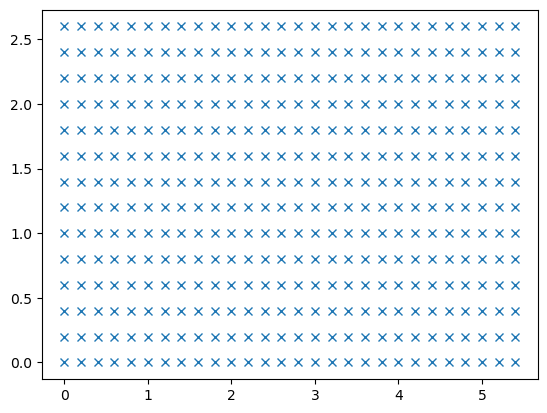

In [3]:
data = pg.getExampleData('ert/Huebner2017/007.dat')
print(data)
plt.plot(pg.x(data), pg.y(data), "x");

In [4]:
data['k'] = ert.geometricFactors(data)
data['rhoa'] = data['k'] * data['r']
data['err'] = 0.02
data

Data: Sensors: 392 data: 2849, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'r', 'rhoa', 'valid']

19/03/24 - 16:35:44 - pyGIMLi - INFO - found 245 x values
19/03/24 - 16:35:44 - pyGIMLi - INFO - found 143 y values
19/03/24 - 16:35:44 - pyGIMLi - INFO - x vector length: 2849
19/03/24 - 16:35:44 - pyGIMLi - INFO - y vector length: 2849
19/03/24 - 16:35:44 - pyGIMLi - INFO - v vector length: 2849
19/03/24 - 16:35:44 - pyGIMLi - INFO - 1390 data of 2849 not shown


(<Axes: xlabel='m', ylabel='a'>,
 <matplotlib.colorbar.Colorbar at 0x14a2e689fa0>)

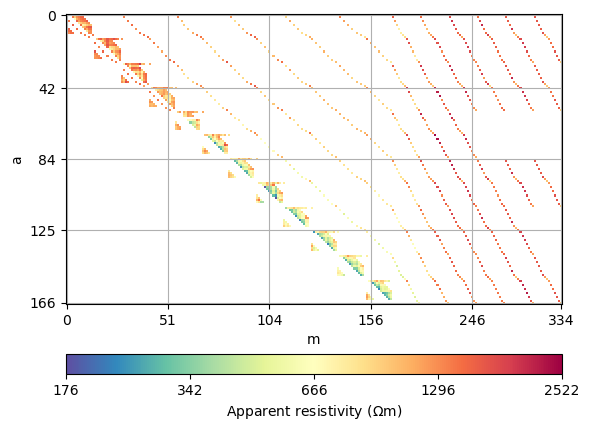

In [5]:
data.show(style='A-M')

Text(0.5, 1.0, 'my data')

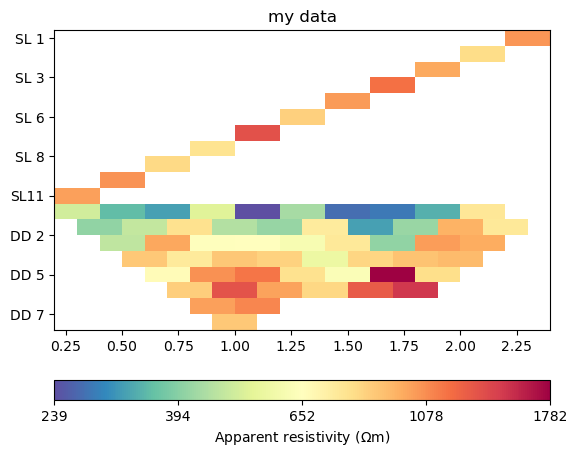

In [6]:
x1 = data.subset(x=1)
epos = np.column_stack([pg.y(x1), pg.y(x1)*0])
x1.setSensors(epos)
x1.sensors()
ax, cb = x1.show()
ax.set_title("my data")

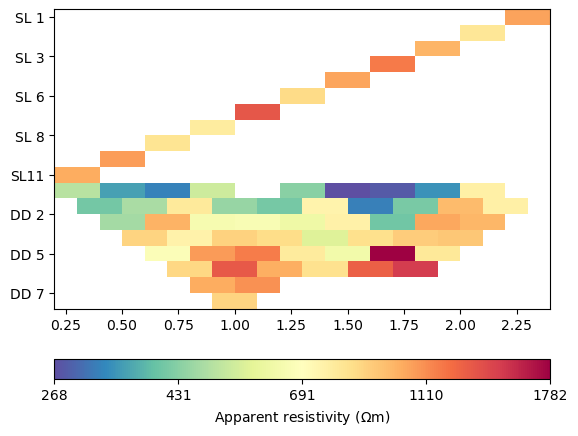

In [7]:
x1.remove(x1["rhoa"] < 250)
x1.show();

In [9]:
mgr = ert.Manager(x1)
mgr.invert(verbose=True)

19/03/24 - 16:36:02 - pyGIMLi - INFO - Found 2 regions.
19/03/24 - 16:36:02 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
19/03/24 - 16:36:02 - pyGIMLi - INFO - Found 2 regions.
19/03/24 - 16:36:02 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
19/03/24 - 16:36:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/03/24 - 16:36:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/03/24 - 16:36:02 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
19/03/24 - 16:36:02 - pyGIMLi - INFO - Use median(data values)=819.2300000000007
19/03/24 - 16:36:02 - pyGIMLi - INFO - Created startmodel from forward operator: 186, min/max=819.230000/819.230000
19/03/24 - 16:36:02 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014A2D509720>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000149F24AA680>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000014A2CE0A680>
min/max (data): 268/1782
min/max (error): 2%/2%
min/max (start model): 819/819
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  467.41
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   76.15 (dPhi = 83.22%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.90 (dPhi = 84.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.92 (dPhi = 31.80%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.92 (dPhi = 0.09%) lam: 20.0
####################

186 [326.80006331324205,...,1215.360952982658]

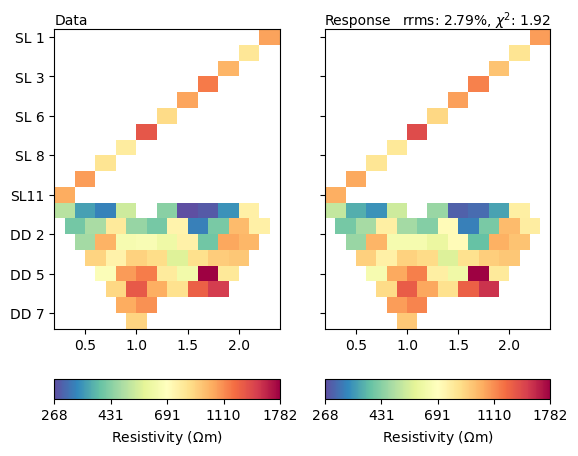

In [10]:
mgr.showFit();

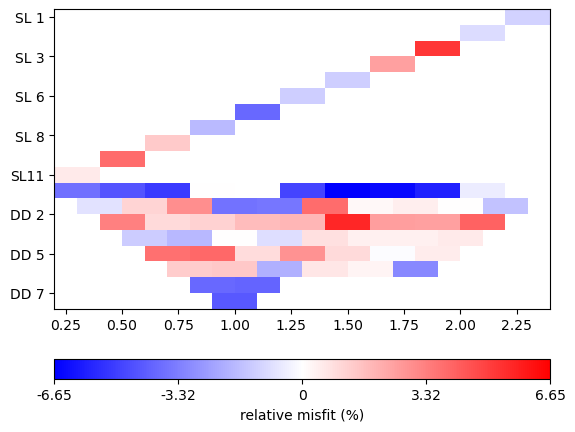

In [11]:
mgr.showMisfit();

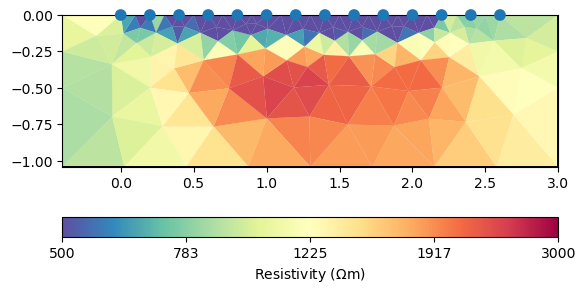

In [18]:
kw = dict(cMin=500, cMax=3000, cMap="Spectral_r",
         logScale=True, coverage=1)
ax, cb = mgr.showResult(**kw)

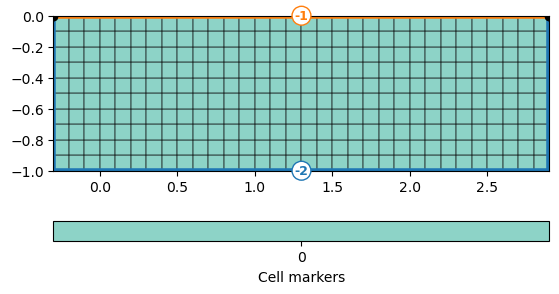

In [24]:
x = np.arange(-0.3, 3, 0.1)
y = np.arange(-1, 0.01, 0.1)
grid = mt.createGrid(x, y, worldBoundaryMarker=True)
pg.show(grid, markers=True, showMesh=True);

In [26]:
pg.setLogLevel(0)

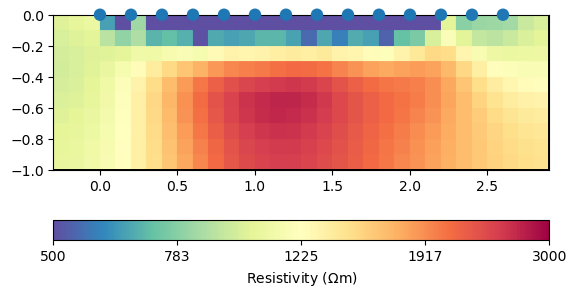

In [28]:
mgr.setMesh(grid)
mgr.invert(verbose=False)
mgr.showResult(**kw);

In [30]:
x1result = mgr.paraDomain
x1result['res'] = mgr.model
x1result

Mesh: Nodes: 363 Cells: 320 Boundaries: 84
Mesh contains data: res

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x14a39c2b040>)

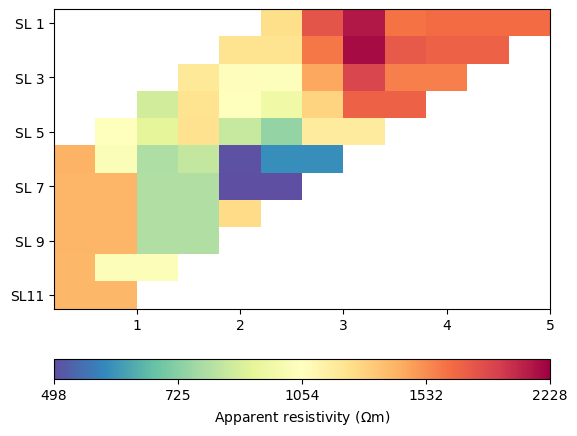

In [34]:
y1 = data.subset(y=0.6)
y1.setSensors(y1.sensors() * np.array([1, 0, 0]))
y1.show()

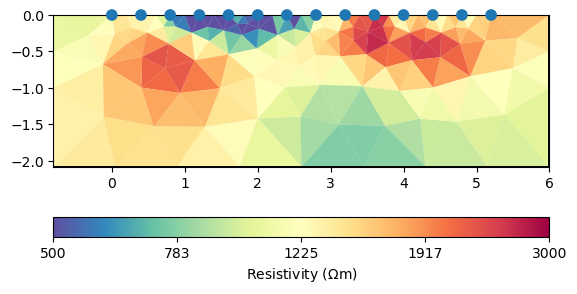

In [35]:
mgr = ert.Manager(y1)
mgr.invert()
mgr.showResult(**kw);

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x14a3e251eb0>)

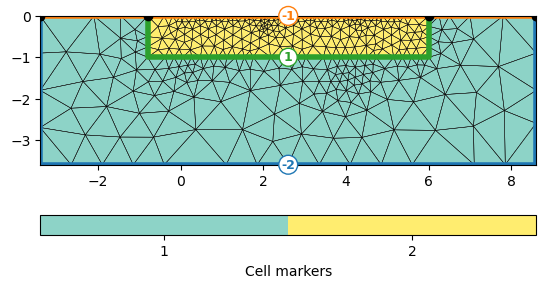

In [46]:
plc = mt.createParaMeshPLC(y1, boundary=0.5,
                          paraDepth=1, paraDX=0.2,
                          paraMaxCellSize=0.05)
mesh = mt.createMesh(plc, quality=34.4, smooth=True)
pg.show(mesh, markers=True, showMesh=True)

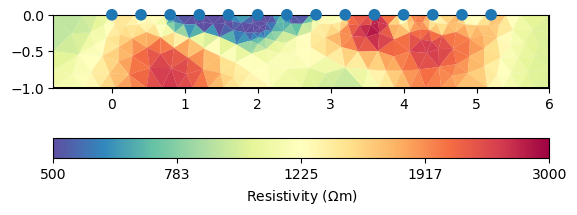

In [48]:
mgr.setMesh(mesh)
mgr.invert()
mgr.showResult(**kw);

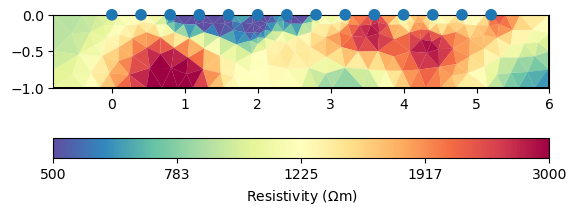

In [49]:
mgr.inv.setRegularization(cType=2)
mgr.invert()
mgr.showResult(**kw);

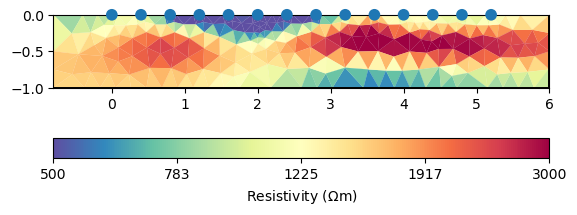

In [50]:
mgr.inv.setRegularization(
    correlationLengths=[1, 0.2])
mgr.invert()
mgr.showResult(**kw);

In [59]:
y1result = mgr.paraDomain
y1result["res"] = mgr.model

In [53]:
kw.pop('coverage')

1

### 3D Visualization

In [60]:
y1result.setDimension(3)
y1result.swapCoordinates(1, 2) # y->z
y1result.translate([0, 0.6, 0])
pg.show(y1result, **kw)

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14a4baf7640_1" src="http://localhost:8888/trame-…

(<pyvista.plotting.plotter.Plotter at 0x14a4baf7640>, None)

In [61]:
x1result.setDimension(3)
x1result.swapCoordinates(1, 2) # y->z
x1result.swapCoordinates(0, 1) # x->y
x1result.translate([1, 0, 0])
pg.show(x1result, **kw);

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14a4cf29460_2" src="http://localhost:8888/trame-…

In [62]:
pl, _ = pg.show(x1result, "res", **kw, hold=True)
pv.drawMesh(pl, y1result, label="res", **kw)
pl.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14a4cfdbb20_3" src="http://localhost:8888/trame-…

In [66]:
plc = mt.createParaMeshPLC3D(data)
mesh = mt.createMesh(plc, quality=1.3)
pg.show(plc, style="wireframe")

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14a4d082f10_7" src="http://localhost:8888/trame-…

(<pyvista.plotting.plotter.Plotter at 0x14a4d082f10>, None)

In [67]:
mgr = ert.Manager(data)
mgr.setMesh(mesh)
mgr.invert(verbose=True)

fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000014A501A8270>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000014A501A8450>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000014A501A8090>
min/max (data): 156/2581
min/max (error): 2%/2%
min/max (start model): 1087/1087
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  429.40
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   27.29 (dPhi = 92.99%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.83 (dPhi = 47.26%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.87 (dPhi = 41.07%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    4.48 (dPhi = 13.50%) lam: 20.0
-----------------

4018 [885.5085377095221,...,555.5007392284718]

In [70]:
result3d = mgr.paraDomain
result3d["res"] = mgr.model
trs = dict(value=400, scalars="res", method="lower")
pl, _ = pg.show(result3d, label="res", style="surface", filter={"threshold": trs}, **kw)
pv.drawMesh(pl, result3d, label="res", style="surface", **kw,
            filter={"slice": dict(normal="y", origin=[0, 1, 0])})
pl.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14a5025c160_10" src="http://localhost:8888/trame…

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14a5025c160_10" src="http://localhost:8888/trame…

In [75]:
DATA = []
for nr in [0, 1, 2, 4, 10, 40]:
    data = pg.getExampleData(f"ert/Huebner2017/{nr:03d}.dat")
    data2d = data.subset(y=1.4)
    data2d.setSensors(data2d.sensors()*np.array([1, 0, 0]))
    DATA.append(data2d)

In [77]:
tl = ert.TimelapseERT(DATA)
tl

Timelapse ERT data:
Data: Sensors: 14 data: 139, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']
6 time steps from 2024-03-19 17:35 to 2024-03-24 17:35

In [78]:
tl.invert(paraDepth=1.3, correlationLength=[1, 0.3])

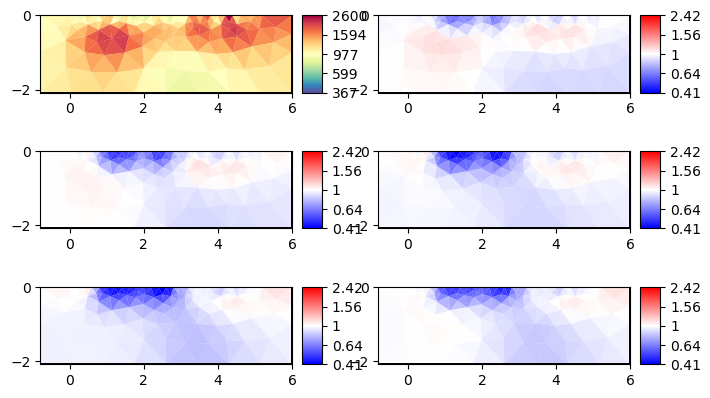

In [82]:
tl.showAllModels(ratio=True, 
                 orientation="vertical");

In [83]:
tl.fullInversion(C=tl.mgr.fop.constraints())

186 model cells
Mesh: Nodes: 760 Cells: 1412 Boundaries: 1112
fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000014AC12019A0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000014AC12084C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000014AC1201310>
min/max (data): 540/2247
min/max (error): 3%/3%
min/max (start model): 1146/1146
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   73.95
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    3.01 (dPhi = 94.95%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.55 (dPhi = 60.69%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.55)                   #
###################################################################

1116 [926.8186870541226,...,1328.4600274488196]

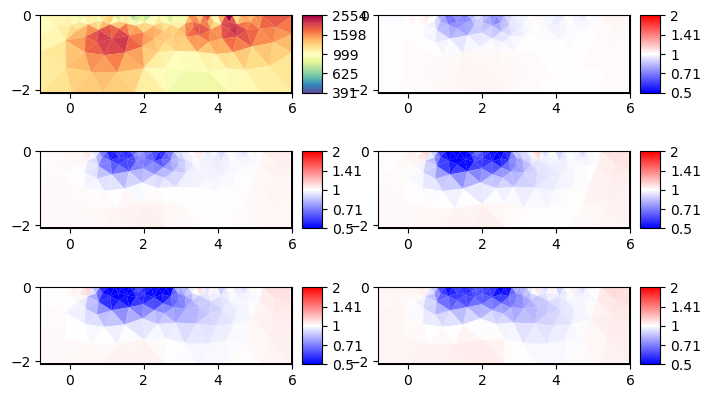

In [86]:
tl.showAllModels(ratio=True, rMax=2,
                 orientation="vertical");